Olist, une entreprise brésilienne qui propose une solution de vente sur les marketplaces en ligne souhaite obtenir une segmentation de ses clients utilisable au quotidien par leur équipe marketing dans leurs campagnes de communication

Objectifs :

Comprendre les différents types d'utilisateurs grâce à leur comportement et à leurs données personnelles

Fournir à Olist, une segmentation de ses clients avec une description actionable de cette segmantation et sa logique sous-jacente

Fournir à Olist, une proposition de contrat de maintenance basée sur une analyse de la stabilité des segments au cours du temps

Pour plus d'informations sur les données : https://www.kaggle.com/olistbr/brazilian-ecommerce

Dans ce troisieme notebook du projet, on va faire une simulation de la stabilité des segments pour répondre au 3eme point de la liste des objectifs, a savoir le contrat de maintenance

In [2]:
# Standards Librairies import

from time import time
from datetime import datetime, timedelta
import warnings
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import homogeneity_score, adjusted_rand_score, adjusted_mutual_info_score


from math import pi

# Clustering Librairies import

from sklearn.cluster import KMeans

from sklearn.metrics import silhouette_score



warnings.filterwarnings('ignore')
plt.rcParams.update({'font.size': 15})
mpl.rcParams["figure.figsize"] = (10, 8)


In [23]:
def calculate_df_period(df, initial, period):

    """cette fonction cree un fichier client en groupant les donnees par 'customer_unique id'
    selon la periode initiale indiquee et/ou 
    selon une periode totale = initiale +period, 
    en calculant les 8 attributs pour chaque client, 
    et retourne les resultats dans un dataframe"""
    
    # Selectioner les donnees par periode

    df['order_purchase_timestamp'] = pd.to_datetime(
        df['order_purchase_timestamp'])

    debut = df["order_purchase_timestamp"].min()

    period = 12 if initial is True else 12 + period

    fin = debut + pd.DateOffset(months=period)

    df = df.loc[(df["order_purchase_timestamp"] >= debut)
                & (df["order_purchase_timestamp"] < fin)]

    # calcul recency par rapport a la date la plus ancienne : plus recency est grande plus la date d'achat est recente

    df['Recency'] = (df['order_purchase_timestamp'] -
                     df["order_purchase_timestamp"].min()).round('1d')

    df['Recency'] = df['Recency'].astype(str).str.replace(
        r'\s+days.*', '', regex=True).astype(int)

    # Group by customers_unique_id with sum or mean

    df = df.groupby("customer_unique_id")\
        .agg(Frequency=("order_id", "nunique"),
             Recency=('Recency', 'max'),
             tot_payment=('payment', 'sum'),
             tot_freight=("freight", "sum"),
             payment_type=("nb_payment_type", "mean"),
             payment_installment=("tot_payment_installment", "mean"),
             rev_score=("review_score", "mean"),             
             #nb_products=("product_id", 'count'),
             nb_items=('quantity', 'sum'))

    # Freight ratio and total price

    df['Monetary'] = df['tot_payment'] + df['tot_freight']
    df = df.drop(['tot_payment', 'tot_freight'], axis=1)
    
    return df


## Contrat de maintenance

Dans le but d'établir un contrat de maintenance de l'algorithme de segmentation client, nous devons tester sa stabilité dans le temps. Pour cela, nous devons recalculer les attributs en fonction d'une période donnée

Adjusted Rand Index (ARI) est une mesure de similarité entre deux partitions d'un ensemble qui va nous permettre de determiner à quel moment les clients changent de Cluster.

D'abord, on va calculer le score ARI pour la premiere annee et ensuite pour les 11 mois suivant (periode totale = 23mois) avec une iteration de 1 mois et en prenant garde à bien comparer les mêmes clients (ceux des 12 mois initiaux).





In [6]:
df_reduit = pd.read_csv("df_reduit.csv")  
df_reduit.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100084 entries, 0 to 100083
Data columns (total 12 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   order_id                  100084 non-null  object 
 1   order_purchase_timestamp  100084 non-null  object 
 2   product_id                100084 non-null  object 
 3   quantity                  100084 non-null  int64  
 4   customer_unique_id        100084 non-null  object 
 5   customer_state            100084 non-null  float64
 6   nb_payment_type           100084 non-null  float64
 7   tot_payment_installment   100084 non-null  float64
 8   payment_value             100084 non-null  float64
 9   review_score              100084 non-null  int64  
 10  payment                   100084 non-null  float64
 11  freight                   100084 non-null  float64
dtypes: float64(6), int64(2), object(4)
memory usage: 9.2+ MB


In [7]:
# la periode totale dans le dataset :

df_reduit['order_purchase_timestamp'] = pd.to_datetime(
    df_reduit['order_purchase_timestamp'])
total_period = int((df_reduit["order_purchase_timestamp"].max(
) - df_reduit["order_purchase_timestamp"].min())/np.timedelta64(1, 'M'))

total_period


23

###  On va calculer ARI pour la premiere annee et ensuite pour les 11 mois suivant en iterant 1 mois (periode totale = 23mois)



In [14]:
# clustering sur les 12 premiers mois du dataset

df_init = calculate_df_period(df_reduit, initial=True, period=1)


In [24]:
# Kmeans on initial period

preprocessor = ColumnTransformer([
    ('scaler', MinMaxScaler(), df_init.columns)])

kmeans_init = Pipeline([("preprocessor", MinMaxScaler()),
                        ("kmeans", KMeans(4, random_state=0))])
kmeans_init.fit(df_init)
init_labels = kmeans_init.named_steps['kmeans'].labels_


In [25]:
ari_score = []
for p in np.arange(1, (total_period-12), 1):
    # Create dataset for period
    df_period = calculate_df_period(df_reduit,
                                    initial=False,
                                    period=p)

    # Filter on initial customer client
    df_period = df_period[df_period.index.isin(df_init.index)]

    # K-Means
    kmeans_p = Pipeline([("preprocessor", MinMaxScaler()),
                         ("kmeans", KMeans(4, random_state=0))])
    kmeans_p.fit(df_period)
    p_labels = kmeans_p.named_steps['kmeans'].labels_

    # Calculate ARI score
    ari_p = adjusted_rand_score(init_labels, kmeans_p[1].labels_)
    ari_score.append([p, ari_p])
print(ari_score)


[[1, 0.9867653946329923], [2, 0.9727123430111965], [3, 0.9463449961476569], [4, 0.8568592606284624], [5, 0.800788595161256], [6, 0.7831236171325702], [7, 0.7697028304674621], [8, 0.45115188606942314], [9, 0.4504406368817926], [10, 0.4499508474832833]]


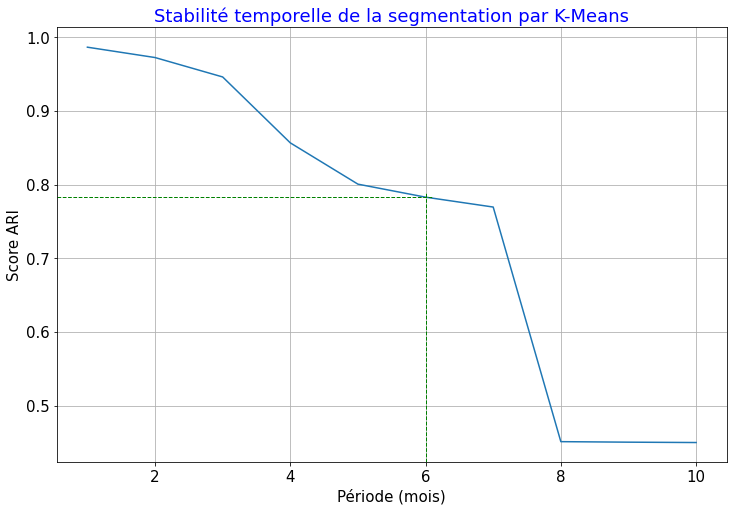

In [35]:
ari_score = pd.DataFrame(ari_score, columns=["periode", "ARI"])

# plot ARI Score
fig = plt.figure(figsize=(12, 8))
sns.lineplot(data=ari_score, x="periode", y="ARI")

plt.axhline(y=ari_score.iloc[5][1], linestyle="--",
            color="green",
            xmax=0.56,
            linewidth=1)
plt.axvline(x=ari_score.iloc[5][0], linestyle="--",
            color="green",
            ymax=0.62,
            linewidth=1)
plt.grid()
plt.xlabel("Période (mois)")
plt.ylabel("Score ARI")
plt.title("Stabilité temporelle de la segmentation par K-Means",
          fontsize=18,
          color="b")

plt.savefig("Stabilité temporelle de la segmentation par K-Means",
            dpi=200, bbox_inches='tight')
plt.show()


## Conclusion :
Selon les scores ARI obtenus sur les itérations par période de 1 mois, il y a une forte inflexion après 7 mois sur les clients initiaux. Il faudra donc prévoir la maintenance du programme de segmentation tous les 6 mois ou le score ARI passe en dessous de 0.8